<a href="https://colab.research.google.com/github/TeachingTextMining/TextClassification/blob/main/04-SA-Transformers-Training-Custom/04_TextClassification_with_Transformers_FeatureComposition_Reviews_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de textos utilizando Transformers. Combinación de características

La clasificación de textos consiste en, dado un texto, asignarle una entre varias categorías. Algunos ejemplos de esta tarea son:

- dado un tweet, categorizar su connotación como positiva, negativa o neutra.
- dado un post de Facebook, clasificarlo como portador de un lenguaje ofensivo o no.  

En la figura se muestra una arquitectura que permite combinar diferentes tipos de características en la construcción de un clasificador para resolver esta tarea. 

La idea general es contar con varios extractores de rasgos para representar el texto, realizar una selección de características y finalmente, entrenar un clasificador con las variables seleccionadas.

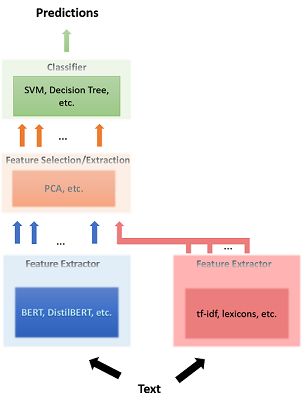

En la actividad exploraremos cómo utilizar la librería [Transformers](https://huggingface.co/transformers/) para construir este modelo y entrenarlo para clasificar reviews de [IMDB](https://www.imdb.com/) sobre películas en las categorías \[$positive$, $negative$\]. 

Como clasificador se utilizará una red neuronal tipo Perceptrón Multicapas, y como características adicionales la representación del texto utilizando [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

Puede encontrar más información sobre este problema en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) y en [Large Movie Review Datase](http://ai.stanford.edu/~amaas/data/sentiment/). También consultar el tutorial sobre [Fine-tunning de modelos](https://huggingface.co/transformers/custom_datasets.html#seq-imdb) en la web del proyecto Transformers.

**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.

**Después de esta actividad nos habremos familiarizado con:**

- la arquitectura de un modelo para clasificar textos que combina diferentes rasgos para representar el texto, por ejemplo, Transformers y otras características propias del dominio.

- el re-entrenamiento de modelos para la clasificación de secuencias.

- aspectos importantes a tener en cuenta como el formato de los datos, y la especificación de las entradas en el modelo.

**Requerimientos**
- python 3.6.12 - 3.8
- tensorflow==2.3.0
- transformers==4.2.1
- pandas==1.1.5
- plotly==4.13.0
- tqdm==4.56.0
- scikit-learn==0.24.0

**Note que:** 
- el propósito principal de la actividad es ilustrar cómo utilizar la librería Transformers para construir modelos que combinen diferentes tipos de características. No necesariamente esta arquitectura conducirá a los mejores resultados.

- en dependencia del entorno de ejecución, puede ser necesario instalar manualmente alguno de estos paquetes.



<a name="setup"></a>
### Instalación de librerías e importación de dependencias.

Para comenzar, es preciso instalar las dependencias, realizar los imports necesarios y definir algunas funciones auxiliares.

Ejecute las siguientes casillas prestando atención a las instrucciones adicionales en los comentarios.

In [ ]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow==2.3.0, etc. que en este caso se encontrarían ya instaladas
%%capture
!pip install transformers==4.2.1

print('Done!')

In [ ]:
# reset environment
%reset -f

# para establecer caminos al guardar y leer archivos
import os

# para cargar datos y realizar pre-procesamiento básico
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

# para evaluar los modelos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# para guardar el modelo
import pickle
import tensorflow as tf

# algoritmos de clasificación, tokenizadores, etc.
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertMainLayer

print('Done!')

In [ ]:
# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs(cfg, data):
  # obtener ids y máscaras para el conjunto de entrenamiento
  # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato, 
  encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])
 

  # obtener representación tf-idf de cada instancia
  tfidf = cfg['vectorizer'].transform(data)
  tfidf_t = tf.convert_to_tensor(tfidf.toarray(), dtype=tf.float32)

  # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
  # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf') 
  # son utilizados como llaves en los diccionarios que representan las entradas al modelo
  inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'tfidf': tfidf_t
           }
          
  return inputs


# función auxiliar para realizar predicciones con el modelo
def predict_model(model, cfg, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """

  inputs = get_model_inputs(cfg, data)
  scores = model.predict(inputs)
  
  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabeticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title={'text' : f'Curva ROC (AUC={auc(fpr, tpr):.4f})', 'x':0.5, 'xanchor': 'center'},
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')
    
    fig_roc.show()

print('Done!')

### Carga de datos y análisis exploratorio

El primer paso consiste en obtener los datos relacionados con nuestra tarea dejándolos en el formato adecuado.  Existen diferentes opciones, entre estas:

- montar nuestra partición de Google Drive y leer un fichero desde esta.

- leer los datos desde un fichero en una carpeta local.

- leer los datos directamente de un URL.

En este caso, se encuentran en un fichero separado por comas con la siguiente estructura:

| Phrase | Sentiment| 
| ------ | ------ |
| This movie is really not all that bad...    | positive |


Ejecute la siguiente casilla para leer los datos.



In [ ]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejercicio_bbc_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejercicio_bbc_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/04-SA-Transformers-Training-Custom/sample_data/ejercicio_bbc_train.csv'

# leer los datos
data = pd.read_csv(path, sep=',')

print('Done!')

Una vez leídos los datos, ejecute la siguiente casilla para construir una gráfica que muestra la distribución de clases en el corpus.


In [ ]:
text_col = 'text'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'category'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=True)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print(f'Distribución de clases -> {{item[0]:round(item[1]/len(data[class_col]), 3) for item in sorted(hist.items(), key=lambda x: x[0])}}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in sorted(hist.keys())]))
fig.show()

print('Done!')

Finalmente, ejecute la siguiente casilla para crear los conjuntos de entrenamiento y validación que se utilizarán para entrenar y validar los modelos.

In [ ]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0  # fijar random_state para reproducibilidad
train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)

print('Done!')

<a name="config_model"></a>
### Implementación y configuración del modelo

Concretamente, en la actividad implementaremos la arquitectura que se muestra en la figura mediante un modelo [Keras](https://www.tensorflow.org/guide/keras?hl=es) *ad-hoc* que permitirá, simultáneamente, hacer fine-tuning de DistilBERT y entrenar el clasificador.

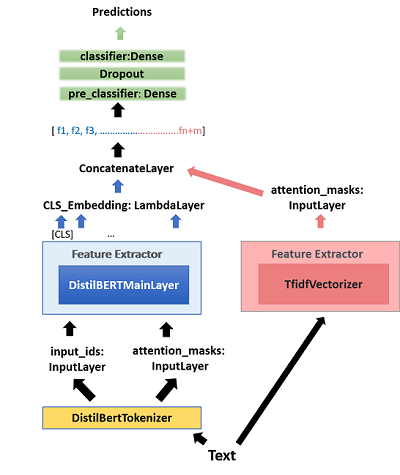

Como puede ver, el modelo consta de:

- un extractor de rasgos basado en Transformers, en particular, una versión pre-entrenada de [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) accesible mediante TFDistilBertMainLayer y [TFDistilBertModel](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel).

- un extractor de rasgos, útil para representar conocimiento específico del dominio. En el ejemplo, utilizando la implementación [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) provista por sklearn.

- un clasificador (red neuronal) que aprenderá a partir de un conjunto de ejemplos donde cada texto se representa a partir de los rasgos obtenidos por los extractores.


**Notar que:**

- en un problema de clasificación multiclases la última capa densa del clasificador debe tener tantas neuronas como posibles categorías contemple el problema. No obstante, en un problema de clasificación binaria, es recomendable tener una sola neurona. Ver *num_labels* en la configuración de DistilBERT.

- el modelo consta de $3$ entradas, dos correspondientes a los id de los tokens y las máscaras que necesita DistilBERT (se obtienen mediante el correspondiente tokenizador) y una entrada correspondiente a los vectores adicionales (se obtiene mediante TfidfVectorizer). 

- la entrada correspondiente al vector de características adicionales (tf-idf) NO es una entrada de TFDistilBertMainLayer, además es conveniente conocer la dimensión de este vector para especificar adecuadamente el shape.


- al tratarse de un modelo Keras, este NO cuenta con funciones *from_pretrained* o *save_pretrained* que nos encontramos en los modelos implementados por Transformers, ej. TFDistilBertForSequenceClassification. Debido a la implementación actual de Transformers, se empleará una solución *ad-hoc* para guardar los pesos del modelo para su posterior uso.

Ejecute las siguientes casillas prestando atención a los comentarios incluidos junto al código.



#### Arquitectura del modelo
En este caso, utilizaremos el API Funcional de Keras para construir el modelo.

**Notar que:**

- debemos cargar la capa que representa al transformer, en este caso, TFDistilBertMainLayer

- dado que la versión actual de Transformers (4.2.1) parece no incluir funcionalidades para cargar los pesos pre-entrenados de TFDistilBertMainLayer, se utiliza la siguiente solución alterna: 
  - (i) cargar algún modelo que contenga esta capa, ej. TFDistilBertModel.
  - (ii) acceder a la capa TFDistilBertMainLayer, que será la que utilizaremos en el modelo. Notar que el nombre de esta capa varía de acuerdo con el modelo base, ej. en TFRobertaModel, la variable que contiene a TFRobertaMainLayer se llama 'roberta'.

Ejecute la siguiente celda para definir una función que crea la estructura del modelo, devolviendo los elementos que representan las entradas y salidas. Estos se emplearán posteriormente al terminar la configuración del modelo.

In [ ]:
def get_model_graph(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = tf.keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = tf.keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32') 

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = tf.keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32') 

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification 
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones 
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = tf.keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features = tf.keras.layers.concatenate([transformes_cls_embedding, input_tfidf], name='concatenate')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = tf.keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier = tf.keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier')(features) 

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer = tf.keras.layers.Dropout(rate=seq_classif_dropout, name='dropout')(pre_classifier)  

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = tf.keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer)

  return input_ids, input_masks, input_tfidf, classifier

print('Done!')

#### Configuración del modelo

Una vez instanciadas y conectadas las capas necesarias, es preciso finalizar la configuración del modelo indicando entre otros:
- cuáles serán las entradas y salidas del modelo.
- el algoritmo de optimización a utilizar.
- las métricas a evaluar, etc.

Se sugiere revisar documentación para más detalles sobre los diferentes hiper-parámetros.

Ejecute la siguiente casilla para definir una función que termina de configurar el modelo previo a su entrenamiento.

In [ ]:
def configure_model(input_ids, input_masks, input_tfidf, classifier):
  # definir algoritmo de optimización
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  # crear el modelo
  model = tf.keras.Model(inputs=[input_ids, input_masks, input_tfidf], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy'])

  return model

print('Done!')

### Instanciar modelo

En este punto, sólo es necesario instanciar el modelo utilizando las funciones definidas con anterioridad.

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 5  # cambiar este número según el número de clases

print('Done!')

In [ ]:
input_ids, input_masks, input_tfidf, classifier = get_model_graph(cfg)
model = configure_model(input_ids, input_masks, input_tfidf, classifier)

# imprimir sumario del modelo 
model.summary()

# graficar el modelo (opcional)
#tf.keras.utils.plot_model(model) 

print('Done!')

### Pre-procesamiento de los datos

Antes de entrenar, debemos pre-procesar los datos. Esto dependerá de la tarea en particular, en este caso, comprende:

- tokenizar para obtener los ids y las máscaras. Debe tener en cuenta que el tokenizador debe ser compatible con el modelo a utilizar, DistilBERT en este caso.

- obtener vectores tf-idf correspondientes a cada ejemplo.

- obtener los vectores one-hot correspondientes a las categorías.

- convertir a tensores cuando sea necesario, pues este será el formato de entrada que se utilizará en el modelo. Los tensores representan una estructura multidimensional de Tensorflow para contener los datos.

**Notar que:**
- es necesario codificar el valor correspondiente a la categoría de modo que pueda procesarse por la red neuronal. Podemos asignar valor *1* a la categoría *positive* y *0* a la *negative*.  En un problema de clasificación multiclases, podemos realizar la codificación mediante un vector one-hot. En la actividad utilizaremos [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) de [scikit-learn](https://scikit-learn.org/stable/).

- en dependencia de su implementación del extractor, deberá re-implementar esta sección.

Ejecute la siguiente casilla prestando atención a los comentarios explicativos.


#### Instanciar tokenizador, tf-idf vectorizer, etc.

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

#### Pre-procesamiento

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs(cfg, train[text_col].to_list())
val_inputs = get_model_inputs(cfg, val[text_col].to_list())

print('Done!')

### Entrenamiento del modelo

Por último es necesario entrenar el modelo.

**Notar que:**
 - se trata de un modelo Keras, por lo que, para guardarlo y utilizarlo posteriormente, se deberán seguir las redomendaciones para este tipo de objeto (https://www.tensorflow.org/guide/keras/save_and_serialize).
 
 - la ejecución puede tomar un tiempo considerable (horas) o fallar por falta de  memoria en dependencia del hardware y parámetros como el batch_size.

- es recomendable guardar checkpoints del modelo cada epochs_to_save iteraciones.



In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints del al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch in tqdm(range(0, epochs_max, epochs_to_save)):
    print('Training model, epochs {0} - {1}'.format(epoch+1, epoch+epochs_to_save))
    
    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, epochs=epochs_to_save, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))
    
    model.save_weights(cfg['trained_model_name'], save_format="tf")
    
print('Done!')

### Evaluación del modelo
Luego de entrenado el modelo, podemos evaluar su desempeño en los conjuntos de entrenamiento y validación.

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de entrenamiento.

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred = predict_model(model, cfg, data[text_col].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de validación. Compare los resultados.

In [ ]:
# predecir los datos de entrenamiento
data = val
true_labels = data[class_col]

m_pred = predict_model(model, cfg, data[text_col].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

## Predicción de nuevos datos

Una vez entrenado el modelo, podemos evaluar su rendimiento en datos no utilizados durante el aprendizaje o emplearlo para predecir nuevas instancias. En cualquier caso, se debe cuidar realizar los pasos de pre-procesamiento necesarios según el caso. En el ejemplo, utilizaremos la porción de prueba preparada inicialmente.

**Notar que**:
-  se cargará el modelo previamente entrenado, estableciendo las configuraciones pertinentes.

- se debe decodificar la salida del modelo para obtener la correspondiente categoría utilizando el mismo codificador.

- si disponemos de un modelo guardado, podremos ejecutar directamente esta parte del cuaderno. Sin embargo, será necesario al menos ejecutar previamente las secciónes [Instalación de librerías...](#setup) e [Implementación y configuración del modelo](#config_model).

### Cargar otros elementos necesarios 

Antes de predecir nuevos datos, también es preciso cargar otros elementos necesarios como el tokenizador, el codificador para las etiquetas, etc.

Ejecute la siguiente casilla.

In [ ]:
# configuraciones
text_col = 'text'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'category'  # columna del dataframe que contiene la clase (depende del formato de los datos)

cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 5  # ver descripción de la sección "Implementación y configuración del modelo"

cfg['checkpoints_dir'] = 'checkpoints'
cfg['model_name'] = 'distilbert-reviews'
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

# cargar tokenizador
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'])

# cargar el codificador one-hot utilizado para codificar las categorías en los datos de entrenamiento
# es necesario para realizar la transformación inversa de la salida de la red y conocer el número de categorías
with open('label_binarizer_reviews.pkl', 'rb') as f:
    cfg['label_binarizer'] = pickle.load(f)


# cargar TfidfVectorizer
with open('vectorizer_reviews.pkl', 'rb') as f:
    cfg['vectorizer'] = pickle.load(f)

print('Done!')

### Instanciar modelo pre-entrenado

Para predecir nuevas instancias es preciso cargar el modelo previamente entrenado. Esto dependerá del formato en el que se exportó el modelo, pero en general se requieren dos elementos: la estructura del modelo y los pesos. En este caso, sólo se han guardado los pesos, por lo que se deberá reconstruir manualmente la estructura del modelo.

Ejecute la siguiente casilla para construir el modelo y cargar los pesos. Para detalles sobre la estructura del modelo puede ver la sección [Implementación y configuración del modelo](#config_model).

In [ ]:
input_ids, input_masks, input_tfidf, classifier = get_model_graph(cfg)
model = configure_model(input_ids, input_masks, input_tfidf, classifier)

# cargar pesos del modelo
model.load_weights(cfg['trained_model_name'])

print('Done!')

### Predecir nuevos datos

Con el modelo y el tokenizador cargados, es posible utilizarlo para analizar nuevos datos. 

Ejecute las siguientes casillas para:

(a) categorizar un texto de muestra.

(b) cargar nuevos datos, categorizarlos y mostrar algunas estadísticas sobre el corpus.

In [ ]:
# ejemplo de texto a clasificar, # lista [texto 1, text 2, ..., texto n]
text = ['Brian De Palma\'s undeniable virtuosity can\'t really camouflage the fact that his plot here is a thinly disguised\
        \"Psycho\" carbon copy, but he does provide a genuinely terrifying climax. His "Blow Out", made the next year, was an improvement.']

m_pred = predict_model(model, cfg, text, pref='m')

pred_labels = m_pred['labels_m'].values[0]
#pred_proba = m_pred['scores_m'].values[0]

print(f'La categoría de la frase es -> {pred_labels}')
#print(f'El score asignado a la clase positiva es -> {pred_proba:.2f}')

print('Done!')


También podemos predecir nuevos datos cargados desde un fichero. 

Ejecute la siguiente casilla, descomentando las instrucciones necesarias según sea el caso.

In [ ]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejercicio_bbc_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejercicio_bbc_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/04-SA-Transformers-Training-Custom/sample_data/ejercicio_bbc_train.csv'

# leer los datos
new_data = pd.read_csv(path, sep=',')

print('Done!')

Ejecute la siguiente celda para predecir los datos y mostrar algunas estadísticas sobre el análisis realizado.

In [ ]:
# predecir los datos de prueba
m_pred = predict_model(model, cfg, new_data[text_col].to_list(), pref='m')
pred_labels = m_pred['labels_m']

# obtener algunas estadísticas sobre la predicción en el conjunto de pruebas
categories = sorted(pred_labels.unique(), reverse=True)
hist = Counter(pred_labels.values) 

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in sorted(hist.keys())]))
fig.show()

print('Done!')